In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tabulate import tabulate

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()
import torch.distributions as td

In [6]:
overview_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/final_selection_runs.csv", index_col=0)
# overview_df = overview_df[overview_df.image_or_language == "image"]

global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[(global_stats_df.index.isin(overview_df.index)) \
                                  & (global_stats_df.phase == "valid")]

overview_df.head()

,objective,l_rate,dataset,image_or_language,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
INFO-VAE l_Rate 0.1 l_MMD 1 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 1 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,1,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,basic_deconv_decoder,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 10 dec: PixelCNN++,INFO-VAE,0.1,bmnist,image,0.0,0,0,10,cond_pixel_cnn_pp,"(20-jan bmnist) INFO-VAE[l_1_rate=0.1, l_2_mmd..."
INFO-VAE l_Rate 0.1 l_MMD 100 dec: CNN.T,INFO-VAE,0.1,bmnist,image,0.0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=0.1, l_2..."


In [7]:
SAVE_DIR = "output_files"

files = [f"{SAVE_DIR}/topic_model_dp_mixtures_kl_comp_dists.pt", f"{SAVE_DIR}/MNIST_dp_mixtures_kl_comp_dists.pt"]

d = torch.load(files[1])
d.keys()

dict_keys(['kl_comp_dists', 'divergence_df'])

In [8]:
all_df, kl_comp_dists = d["divergence_df"], d["kl_comp_dists"]

 48/49


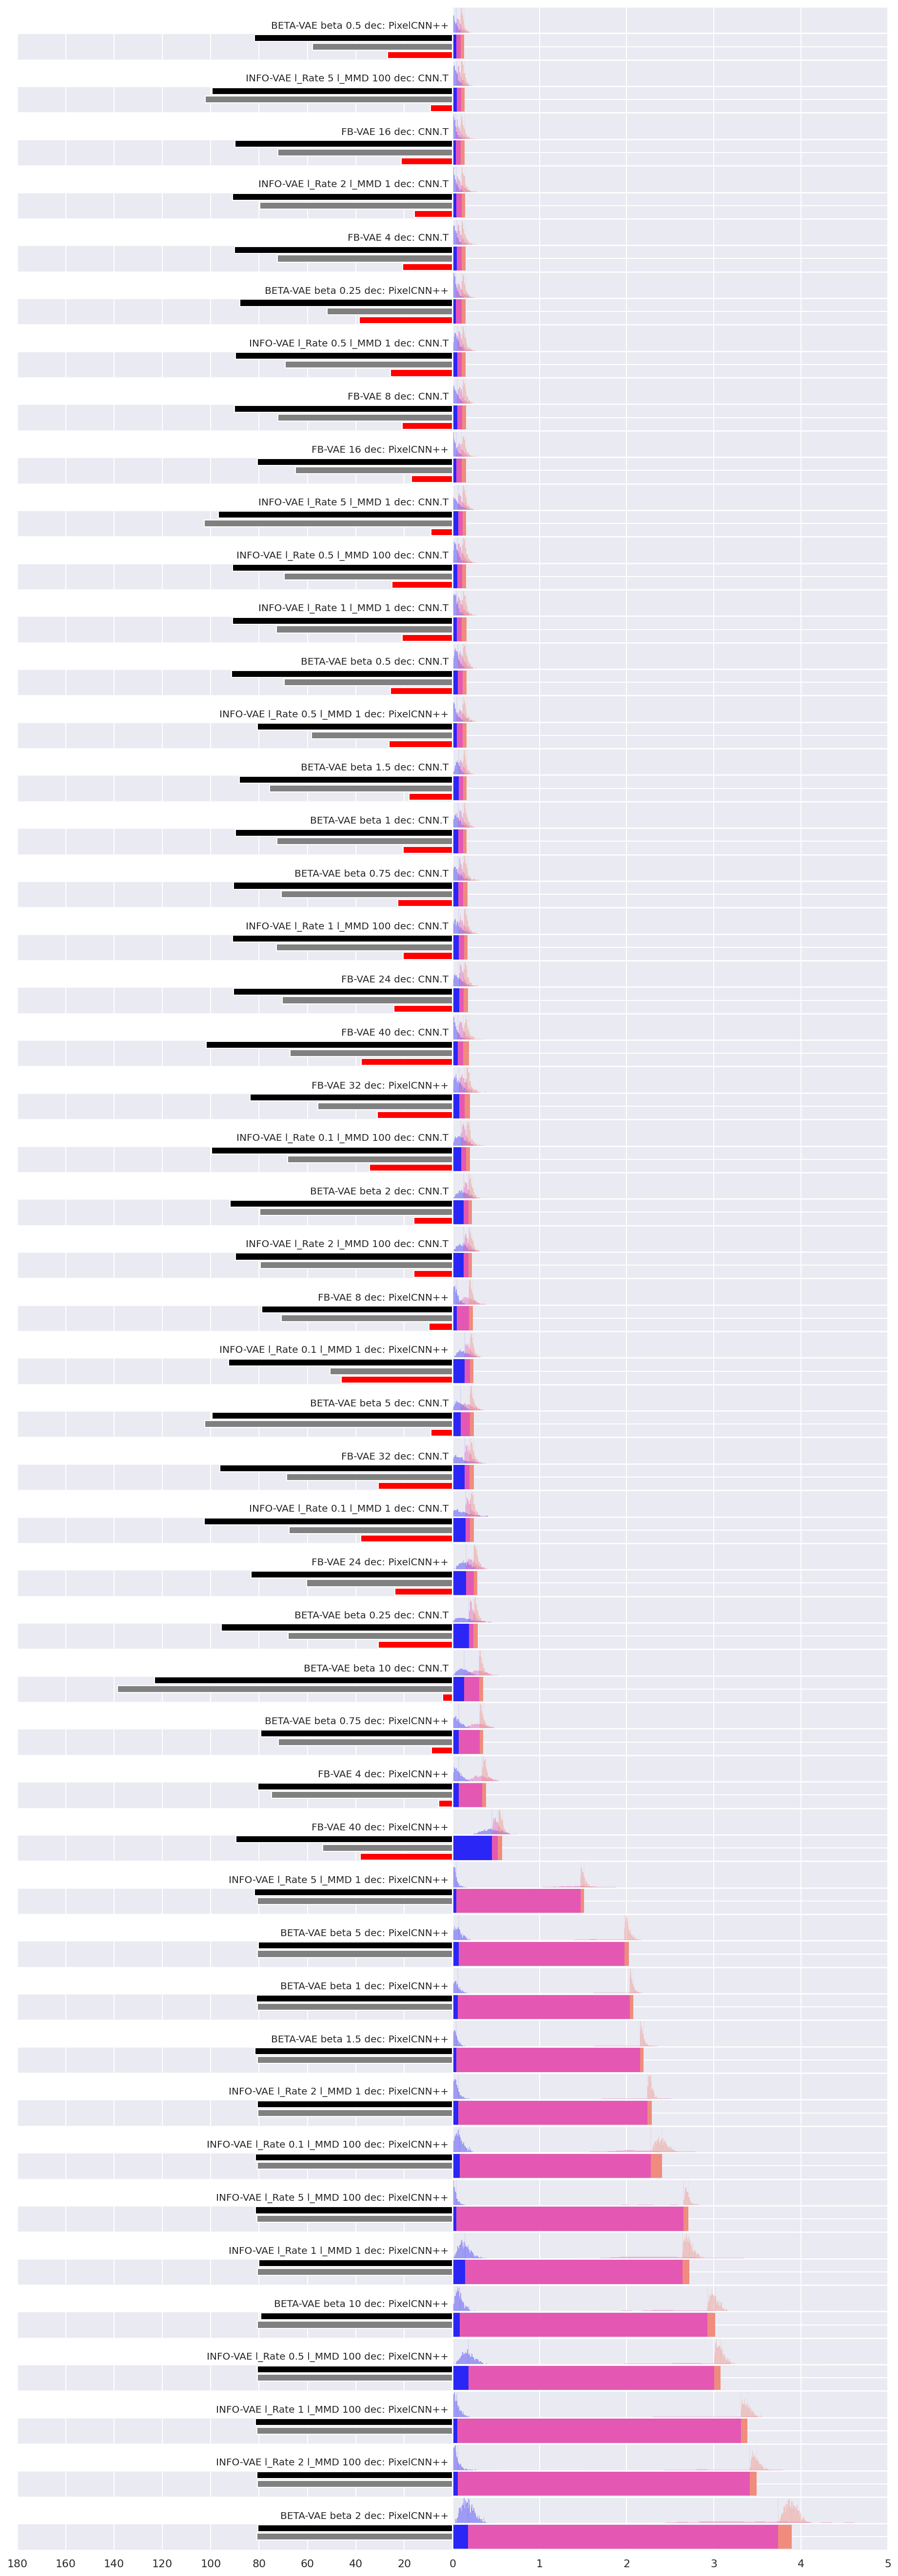

In [12]:
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

# plt.rcParams['axes.grid'] = False
# plt.rcParams['axes.facecolor'] = "white"

N_groups = len(list(kl_comp_dists.values())[0])

c_dict = {"unconditional_unconditional": "#2A26F5",
          "conditional_conditional": "#E458B3",
          "unconditional_conditional": "#EF8C7D"}

max_groups = N_groups - 1 # -1 for data_group

height_ratios = []
for _ in range(max_groups):
    height_ratios.extend([1, 1])
    
fig = plt.figure(figsize=(8*2, 1.0*max_groups)) #constrained_layout=True, 
gs = GridSpec(ncols=2, 
              nrows=max_groups*2, 
              figure=fig, 
              height_ratios=height_ratios, 
              wspace=0.0, 
              hspace=0.0)
# fig, axs = plt.subplots(ncols=2, nrows=max_groups*2, figsize=(5*2, 0.5*max_groups), sharex="col", 
#                         gridspec_kw={"height_ratios":height_ratios})


stats = ["unconditional_unconditional", "conditional_conditional", "unconditional_conditional"]
group_names = all_df.sort_values("kl_comp sum").index.values

max_xlim = 5.0

col = 1
group_n = 0

for i, group_name in enumerate(group_names):
    print(f"{i:3d}/{len(group_names)}", end="\r")
    
    #print(group_n, group_name)

    if group_name == "data_group":
        continue
        
    avg_prev = 0.0
    cum_avgs = [0.0]
    avgs = []
    
    row = group_n * 2
    
    ax = fig.add_subplot(gs[row, col])
    ax1 = fig.add_subplot(gs[row+1, col])
    
    for stat in stats:
        
        kl_comp_vals = kl_comp_dists[stat][group_name]
        
        ax.hist(np.array(kl_comp_vals)+avg_prev, bins=60, density=True, lw=0, 
                      color=c_dict[stat], alpha=0.4)
        
        avg = np.mean(kl_comp_vals)
        avgs.append(avg)
        avg_prev += avg
        cum_avgs.append(avg_prev)
        
        ax.axvline(avg_prev, color=c_dict[stat], linestyle='--', lw=0.1)
        ax.set_yticks([])
        ax.set_xlim([0.0, max_xlim])
    
    for i in range(3):
        ax1.barh([''], [avgs[i]], left=[cum_avgs[i]], color=c_dict[stats[i]], lw=0, height=0.1)
    
    ax.set_ylabel(group_name, rotation="horizontal", ha='right', size=10, y=0.1)
    ax1.set_xlim([0.0, max_xlim])

    ax.set_xticklabels([])
    if (group_n + 1) != (len(group_names) - 1):
        ax1.set_xticklabels([])
    
    group_n += 1
    
print()

col = 0
group_n = 0
for i, group_name in enumerate(group_names):
    print(f"{i:3d}/{len(group_names)}", end='\r')
    
    if group_name == "data_group":
        continue
    
    row = group_n * 2
    ax = fig.add_subplot(gs[row+1:row+2, col])
    
    # Get R, D, LL values for group
    select = global_stats_df[global_stats_df.index == group_name]
    nll, r, d = - select["IW LL"].values[0], select["kl_prior_post"].values[0], select["distortion"].values[0]
    
    # Grouped bar
    widths = [r, d, nll]
    ax.barh(["Rate", "Distortion", "NLL"], width=widths, color=['red', 'grey', 'black'])
    
    # Ticks and lims
    ax.set_yticks([])
    ax.set_xlim(180, 0)
    if (group_n + 1) != (len(group_names) - 1):
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(MaxNLocator(prune='lower'))
    
    group_n += 1

plt.subplots_adjust(wspace=0.0, hspace=0)